In [1]:
import numpy as np
import ast
import matplotlib.pyplot as plt
import os

In [2]:
path = '/global/homes/e/ecastori/PostBorn/output/'

In [3]:
#cosmology
h         = 0.6770
omega_cdm = 0.11923
omega_b   = 0.02247
Omega_b   = omega_b/h**2
Omega_cdm = omega_cdm/h**2
Omega_m   = Omega_b+Omega_cdm
ns        = 0.96824
A0        = 2.10732*10**(-9)

#dictionary for class
cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
print(cosmo_dict)


c      = 299792458/1000. #km/s

#prefactor for Cl_kk computation from Cl_dd
prefac = 1.5*Omega_m*(100.)**2/c**2 #without h

{'h': 0.677, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'A_s': 2.10732e-09, 'n_s': 0.96824, 'k_pivot': 0.05}


In [4]:
#get comoving distance from integrating c/H_0/E(z)
def integrand(z):
    return c/(100.)*(Omega_m*(1.+z)**3+(1.-Omega_m))**(-0.5)#Mpc/h

def chi(z):
    z_ = np.arange(0.,z,0.0001)
    res = np.trapz(integrand(z_),z_)
    return res

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


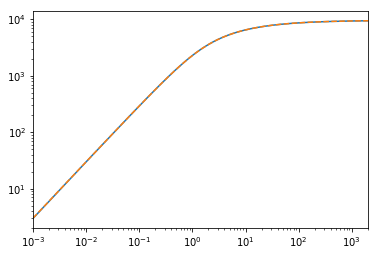

In [5]:
#get z_cmb and comving distance from class

from classy import Class
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
cosmo_b               = cosmo.get_background()

class_z               = cosmo_b['z'][::-1]
class_chi             = cosmo_b['comov. dist.'][::-1]

derivParams           = cosmo.get_current_derived_parameters(['z_rec'])
z_cmb                 = derivParams['z_rec']


from scipy.interpolate import InterpolatedUnivariateSpline as ius
chi_z = ius(class_z,class_chi*h)#Mpc/h

#check if interpolation works
z_=np.logspace(-3,3.5)
plt.figure()
plt.loglog(class_z,class_chi*h)
plt.loglog(z_,chi_z(z_),ls='--')
plt.xlim(0,2000)
plt.show()

In [6]:
#read in ells and header of one file, compare chis in header with computed ones
fname= 'C_ell_z1_0.070000_z2_0.071157_lmin2_lmax2000_nd-4.dat'
data = np.loadtxt(path+fname,skiprows=1)
ell  = data[:,0]

with open(path+fname) as f:
    a= f.readline().split(',')
    f.close()
print(a)
print('chi(z1) Class', chi_z(0.070000))
print('my chi(z1)', chi(0.070000))
print('chi(z2), CLASS',chi_z(0.071157))

#set chi_cmb
chi_cmb = chi(z_cmb)*h
print('Distance to CMB:',chi_cmb)

[' C_ell(z1', 'z2)', ' z1 = 0.07', ' z2 = 0.071157', ' chi(z1) = 206.54735', ' chi(z2) = 209.89216\n']
chi(z1) Class 206.40259309804688
my chi(z1) 206.1145755185435
chi(z2), CLASS 209.75547088368387
Distance to CMB: 6405.286756852273


low z1: [0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.23 0.25 0.27 0.29 0.31
 0.33 0.35 0.37 0.39 0.41 0.43 0.45 0.47 0.49 0.51 0.53 0.55 0.57 0.59
 0.61 0.63 0.65 0.67 0.69 0.71 0.73 0.75 0.77 0.79 0.81 0.83 0.85 0.87
 0.89 0.91 0.93 0.95 0.97 0.99]
377
245
183
147
122
105
92
82
73
66
61
56
52
48
45
42
40
37
35
33
32
30
29
28
26
25
24
23
22
22
21
20
19
19
18
17
17
16
16
15
15
15
14
14
13
13
13
12
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


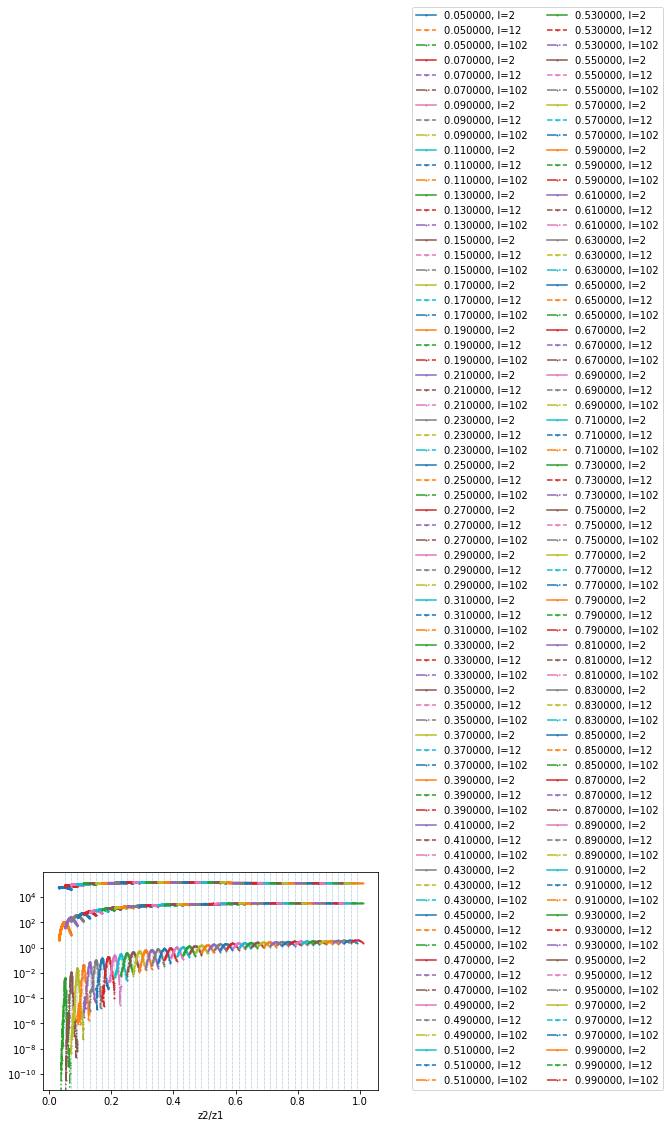

In [9]:
import fnmatch
#not very elegant, but seems to do the job: read in Cdd_ells

# this is the loop for low redshifts

z1s1 = np.arange(0.05,1.01,0.02)
#z1s1 = np.insert(z1s1,0,np.arange(0.1,0.2,0.05))

print('low z1:',z1s1)

C_ells1 = []
z2s1 = []
z1_=[]
for z1 in z1s1:
    z2=[]
    C_ells=[]
    for file in os.listdir(path):
        if fnmatch.fnmatch(file, 'C_ell_z1_%.6f_z2*_lmin2_lmax2000_nd-4.dat'%z1):
            z1_+=[z1]
            
            C_ells +=[np.loadtxt(path+file,skiprows=1)[:,1]]
            try:
                z2+=[ast.literal_eval(file[21:29])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[21:28])]
                except:
                    z2+=[ast.literal_eval(file[21:27])]


        if fnmatch.fnmatch(file,'C_ell_z1_%.5f_z2*_lmin2_lmax2000_nd-4.dat'%z1):
            z1_+=[z1]
            C_ells +=[np.loadtxt(path+file,skiprows=1)[:,1]]

            try:
                z2+=[ast.literal_eval(file[20:28])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[20:27])]
                except:
                    z2+=[ast.literal_eval(file[20:26])]

    print(len(z2))
    assert(len(z2)==len(np.unique(z2)))
    z2 = np.asarray(z2)
    ii = np.argsort(z2)
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,0]),marker='o',markersize='1',label='%f, l=%d'%(z1,ell[0]))
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,10]),marker='o',ls='--',markersize='1',label='%f, l=%d'%(z1,ell[10]))
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,100]),marker='o',ls='-.',markersize='1',label='%f, l=%d'%(z1,ell[100]))
    plt.axvline(z1,lw=0.5,ls=':')
    z2s1+=[z2[ii]]
    C_ells1+=[np.asarray(C_ells)[ii,:]]
plt.savefig('../figures/plot_Cells_lowz1.png',bbox_inches='tight')
plt.xlabel('z2/z1')
plt.legend(ncol=2,loc=(1.1,0))
print(z1s1-np.unique(z1_))

high z1: [1.05 1.25 1.45 1.65 1.85 2.05 2.25 2.45 2.65 2.85 3.05 3.25 3.45 3.65
 3.85 4.05 4.25 4.45 4.65 4.85 5.05 5.25 5.45 5.65 5.85 6.05 6.25 6.45
 6.65 6.85 7.05 7.25 7.45 7.65 7.85 8.05 8.25 8.45 8.65 8.85 9.05]
115
90
73
60
51
44
38
33
30
27
24
22
20
18
17
16
15
14
13
12
11
11
10
9
9
9
8
8
7
7
7
7
6
6
6
6
5
5
5
5
5
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


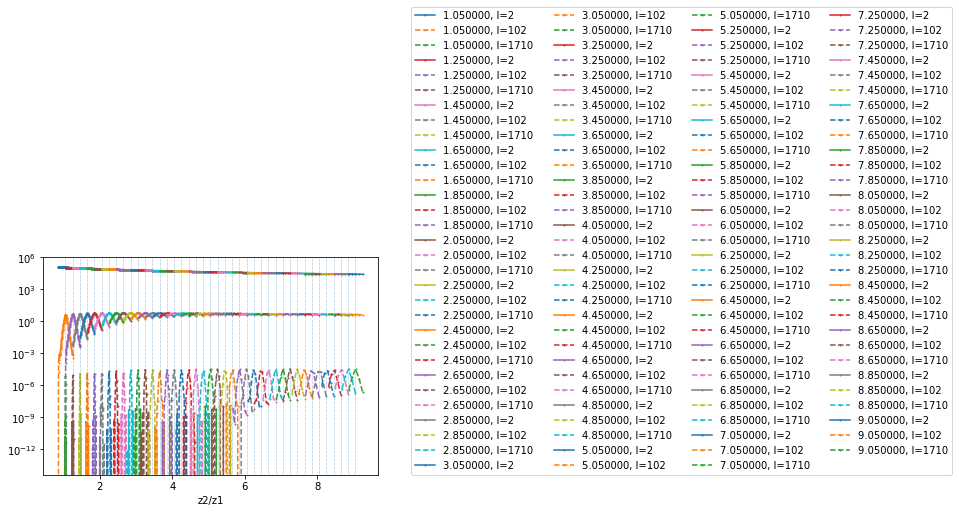

In [16]:
#high redshift z1s
#loop over these z1s
z1s2 = np.arange(1.05,9.1,0.2)

print('high z1:', z1s2)
ll_=0
C_ells2 = []
z2s2 = []
z1_=[]
plt.figure()
for z1 in z1s2:
    z2=[]
    C_ells=[]
    for file in os.listdir(path):
        if fnmatch.fnmatch(file, 'C_ell_z1_%.4f_z2*.dat'%z1):
            z1_+=[z1]
            C_ells+=[np.loadtxt(path+file,skiprows=1)[:,1]]
            try:
                z2+=[ast.literal_eval(file[19:26])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[19:25])]
                except:
                    z2+=[ast.literal_eval(file[19:24])]
                    
    assert(len(z2)==len(np.unique(z2)))
    print(len(z2))
    z2 = np.asarray(z2)
    ii = np.argsort(z2)
    plt.semilogy(z2[ii],np.asarray(C_ells)[ii,0],marker='o',markersize='1',label='%f, l=%d'%(z1,ell[0]))
    plt.semilogy(z2[ii],np.asarray(C_ells)[ii,100],ls='--',marker='o',markersize='1',label='%f, l=%d'%(z1,ell[100]))
    plt.semilogy(z2[ii],np.asarray(C_ells)[ii,500],ls='--',marker='o',markersize='1',label='%f, l=%d'%(z1,ell[500]))
    plt.axvline(z1,lw=0.5,ls=':')
    z2s2+=[z2[ii]]
    C_ells2+=[np.asarray(C_ells)[ii,:]]
plt.legend(ncol=4,loc=(1.1,0))
plt.xlabel('z2/z1')
plt.savefig('../figures/plot_Cells_highz1.png',bbox_inches='tight')

print(z1s2-np.unique(z1_))
z2s2=np.asarray(z2s2)

In [56]:

C_ells1 = np.asarray(C_ells1)
C_ells2 = np.asarray(C_ells2)


C_ells  = np.append(C_ells1,C_ells2)

print(C_ells1.shape)
print(C_ells2.shape)
print(C_ells.shape)




z2s1 = np.asarray(z2s1)
z2s2 = np.asarray(z2s2)
z2s  = np.append(z2s1,z2s2)
z2s  = np.asarray(z2s)


print(z2s1.shape)
print(z2s2.shape)
print(z2s.shape)

#z1s = np.arange(1.0,5.0,0.2)

z1s = np.concatenate((z1s1,z1s2))

# C_ells_t = []
# for ll in range(len(ell)):
#     for ii in range(len(z1s)):
#         if ii ==0:
#             C_ell_ = C_ells[ii][:,ll]
#         else:
#             C_ell_ = np.hstack((C_ell_,C_ells[ii][:,ll]))  
#     C_ells_t+=[np.array(C_ell_)]

# # for ll in range(len(ell)):
# #     for ii in range(len(z1s)):
# #         a = C_ells_t[ll][ii]
# #         for jj in range(len(z2s[ii])):
# #             np.append(a,C_ells_t[ll][:][jj])

#print(z1s)
print(np.asarray(C_ells[[ii for ii in range(len(z1s))]]).shape)

(48,)
(41,)
(89,)
(48,)
(41,)
(89,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(3373,)
(337

In [ ]:
def lensing_kernel(chi_max, chi_z):
    def kernel(z):
        chi = chi_z(z)
        return (chi_max-chi)/(chi_max*chi)*(1.+z)
    return kernel

In [ ]:
W = lensing_kernel(chi_cmb, chi_z)
z_= np.linspace(1e-5,5,200)
#plt.semilogy(z_,-W(z_))
plt.semilogy(z_,W(z_))

In [ ]:
#chi(z1)
chi1 = chi_z(z1s)
CLkk = []
#ell indices
index = [0,2,3,4,5,8,10,20,40,50,100,200,500]
f1, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
f2, ax = plt.subplots()
for ll in index:
    res=[]
    for jj, z1 in enumerate(z1s):
        z2_ = z2s[jj]
        C_ell = np.asarray(C_ells[jj])[:,ll]
        ax1.loglog(z2_,C_ell,ls='-')
        ax2.loglog(z2_,W(z2_)*C_ell,ls='-')
        res+=[np.trapz(W(z2_)*C_ell,chi_z(z2_))]
    CLkk+=[np.trapz(res*W(z1s),chi1)]
    
    ax.semilogy(z1s,res*W(z1s),marker='o',markersize=1)
ax3.semilogy(z1s,W(z1s),marker='o',markersize=1)
ax2.set_xlabel('$z_2$')   
ax.set_xlabel('$z_1$')
L = ell[index]
CLkk = (L*(L+1.))**2*np.asarray(CLkk)*prefac**2        
    

In [ ]:
cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
cosmo_dict['output']='lCl, tCl'
cosmo_dict['l_max_scalars']=2000
cosmo_dict['lensing']='yes'

In [ ]:
cosmo.empty()
cosmo.set(cosmo_dict)

In [ ]:
cosmo.compute()

In [ ]:
cllen= cosmo.lensed_cl(lmax=1000)

In [ ]:
ll = cllen['ell']
clpp = cllen['pp']

In [ ]:
plt.figure()

plt.loglog(ll,1./4.*(ll*(ll+1))**2*clpp,ls='',marker='o',label='CLASS')
plt.loglog(L,CLkk,ls='',marker='+',label='CL_pp integration')
plt.ylabel('$[L(L+1)]^2 C_L^{\phi\phi}/4$',fontsize=14)
plt.xlabel('$L$')
plt.xlim(2,2000)
plt.legend()
plt.savefig('../figures/Clkk_from_Clpp.png',bbox_inches='tight')
plt.show()

In [ ]:
# ratio plot
if len(L)<len(clpp):
    clpp = np.interp(L,ll,clpp)
plt.figure()
plt.semilogx(L,(L*(L+1.))**2*clpp/CLkk/4.,ls='',marker='o',label='CL_dd integration')
plt.ylabel('ratio',fontsize=14)
plt.xlabel('$L$')
plt.xlim(2,2000)
plt.ylim(0,4)
plt.axhline(1)
plt.legend()
plt.savefig('../figures/Clkk_from_Clpp_ratio.png',bbox_inches='tight')
plt.show()